In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, math
from matplotlib.colors import hsv_to_rgb
import matplotlib

from numba import jit, cuda, prange
import cv2


In [2]:
print(cuda.gpus)
!nvidia-smi

<Managed Device 0>
Fri Nov 12 12:27:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   47C    P8    N/A /  N/A |     68MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

In [3]:
@jit(nopython=True)
def f(x):
    return (x[0]**2+x[1]-11)**2+(x[0]+x[1]**2-7)**2

@jit(nopython=True)
def df(x):
    dfx1=2*(x[0]**2+x[1]-11)*(2*x[0])+2*(x[0]+x[1]**2-7)*(1)
    dfx2=2*(x[0]**2+x[1]-11)*(1)+2*(x[0]+x[1]**2-7)*(2*x[1])
    return np.array([dfx1,dfx2])

In [4]:
@jit(nopython=True)
def gradientDecent(x):
    lr=0.01
    tol=1e-10
    for i in range(100):
        der=df(x)
        x=x-lr*der
        if(np.all(np.abs(der*lr)<=tol)):
            break
    return x

In [5]:
@cuda.jit
def get_grid_cuda(Z):
    lr=0.01
    tol=1e-10
    i, j = cuda.grid(2)
    if i >=0 and i < Z.shape[0] and j >=0 and j < Z.shape[1]:
        x = Z[i,j,:]
        for i in range(100):
            dfx1=2*(x[0]**2+x[1]-11)*(2*x[0])+2*(x[0]+x[1]**2-7)*(1)
            dfx2=2*(x[0]**2+x[1]-11)*(1)+2*(x[0]+x[1]**2-7)*(2*x[1])
            x[0]=x[0]-lr*dfx1
            x[1]=x[1]-lr*dfx2
            # if(abs(dfx1*lr)<=tol and abs(dfx2*lr)<=tol):
            #     break
        Z[i, j, 0] = x[0]
        Z[i, j, 1] = x[1]
          

In [6]:
@jit(nopython=True, parallel=True)
def get_grid(Z):
    for i in prange(len(Z)):
        for j in prange(len(Z[0])):
            Z[i,j,:]=gradientDecent(Z[i,j,:])
    return Z

In [7]:
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

Time taken: 0.16156768798828125
[-4. -3.  3.  4.]


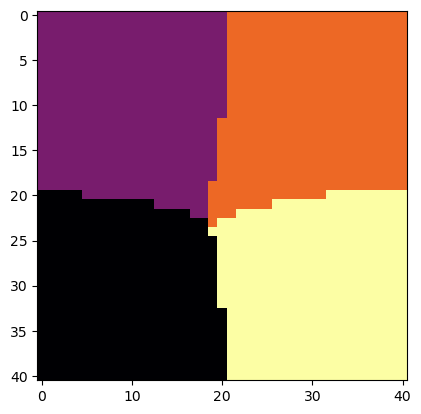

In [9]:
N=16384
N=12288
N=8192
N=4096
N=256
N=41
x=np.linspace(-5,5,N)
xx,yy=np.meshgrid(x,x)
z=f([xx,yy])
# dy1,dy2=df([xx,yy])
# plt.contourf(xx,yy,z,levels=50)
# plt.imshow(np.flip(z,0))
# plt.gca().set_aspect('equal')
# plt.show()
# plt.close()

# x=gradientDecent(np.array([0.,0.]))
# Z=np.zeros((N,N,2))

# Z=np.stack([xx,yy],axis=-1)
# start = time.time()
# Z=get_grid(Z)
# print("Time taken:",time.time() - start)

Z=np.stack([xx,yy],axis=-1)
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(Z.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(Z.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
get_grid_cuda[blockspergrid, threadsperblock](Z)
print("Time taken:",time.time() - start)

Val=np.flip(Z[:,:,0]**2+Z[:,:,1]**2,0)
# Val=(normalize(Val)+normalize(np.flip(z,0)))/2

roundOff=0
# minima=np.unique(Val.round(roundOff))
minimaX=np.unique(Z[:,:,0].round(roundOff))
# minimaY=np.unique(Z[:,:,1].round(roundOff))

print(minimaX)
# print(minimaY)

Img=np.zeros((Val.shape[0],Val.shape[1],3)).astype(np.uint8)
cmap = matplotlib.cm.get_cmap('inferno')
# print(minima)
for i in  range(len(minimaX)):
    # indx=np.argwhere(Val.round(3)==minima[i])
    indx=np.argwhere(np.flip(Z[:,:,0],0).round(roundOff)==minimaX[i])
    
    rgba = cmap(i/(len(minimaX)-1))
    Img[indx[:,0],indx[:,1],:]=np.array(rgba[:-1])*255
    
plt.imshow(Img)
plt.gca().set_aspect('equal')
plt.savefig("fig.png",dpi=600)
# cv2.imwrite('fig.png',cv2.cvtColor(Img, cv2.COLOR_RGB2BGR))
plt.show()
plt.close()


In [ ]:
# minimaX=np.unique(Z[:,:,0].round(5))
# minimaY=np.unique(Z[:,:,1].round(5))
# print(minimaX)
# print(minimaY)

# indx=np.argwhere(Z[:,:,0].round(5)==minimaX[0]) #and np.argwhere(Z[:,:,1].round(5)==minimaY[0])
# print(indx[0])
# indx=np.argwhere(Z[:,:,1].round(5)==minimaY[0])
# print(indx[0])

minima=np.unique(Val.round(5))
Img=np.zeros((Val.shape[0],Val.shape[1],3)).astype(np.uint8)
cmap = matplotlib.cm.get_cmap('viridis')
for i in  range(len(minima)):
    indx=np.argwhere(Val.round(5)==minima[i])
    rgba = cmap(i/(len(minima)-1))
    Img[indx[:,0],indx[:,1],:]=np.array(rgba[:-1])*255
    

plt.imshow(Img)
plt.gca().set_aspect('equal')
# cv2.imwrite('fig.png',(Val*255).astype(np.uint8))
plt.show()
plt.close()

# print(arr)
